In [35]:
#%reset
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import eli5
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
## read data 
CIP_data = pd.read_csv("CIP_data_encode_prev.csv")
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)
hfont = {'fontname':'Helvetica'}


Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'CLINIC', 'YEAR',
       'GENDERSP', 'Susceptible', 'MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing',
       'REGION', 'Midwest', 'Northeast', 'Southeast', 'Southwest', 'West',
       'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION'],
      dtype='object')


ALB
0.0728476821192053
ATL
0.056910569105691054
BAL
0.01444043321299639
BHM
0.010948905109489052
CHI
0.04054054054054054
CIN
0.006666666666666667
CLE
0.030612244897959183
DAL
0.060810810810810814
DEN
0.15699658703071673
DTR
0.0033333333333333335
GRB
0.017341040462427744
HON
0.35789473684210527
HON
0.35789473684210527
LAX
0.22705314009661837
LBC
0.2835820895522388
LVG
0.08666666666666667
MIA
0.19811320754716982
MIN
0.05652173913043478
NOR
0.10204081632653061
NYC
0.07547169811320754
OKC
0.043333333333333335
ORA
0.3458646616541353
ORA
0.3458646616541353
PHI
0.30333333333333334
PHX
0.11851851851851852
POR
0.27218934911242604
SDG
0.3511450381679389
SDG
0.3511450381679389
SEA
0.3181818181818182
SFO
0.44481605351170567
SFO
0.44481605351170567


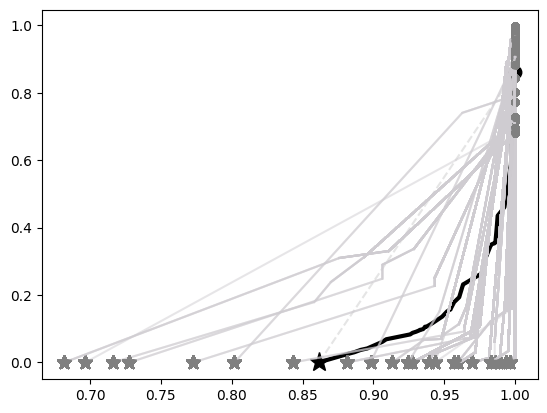

In [50]:
#### LOOCV based on clinic

#get all clinics 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
threshold_seq = np.linspace(0,1,101)

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
years_train = [2000, 2001, 2002, 2003, 2004]
year = [2006]
### subset data based on year FIRST to esnure only clinics that appear in that year are used 
CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(year)]

## first plot overall with all clinics as a base of comparison 
X_train = CIP_data_training_years[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
y_train = 1 - CIP_data_training_years['Susceptible']
X_test = CIP_data_testing_years[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
y_test = 1 - CIP_data_testing_years['Susceptible']
cipro_R_prev = y_test.sum()/len(y_test)

X_test, y_test = oversample.fit_resample(X_test,y_test)
model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)
get_effective_threshold_prev_all_clinics = []
incorrectly_get_X_threshold_prev_all_clinics = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

        sensitivity_test  = tp_test  / (tp_test   + fn_test )
        specificity_test   = tn_test / (tn_test + fp_test )
    
        get_effective_threshold_prev_all_clinics.append(sensitivity_test * cipro_R_prev + (1 -  cipro_R_prev)) #q_p
        incorrectly_get_X_threshold_prev_all_clinics.append((1 - cipro_R_prev) * (1 - specificity_test)) #c_p
plt.plot(get_effective_threshold_prev_all_clinics, incorrectly_get_X_threshold_prev_all_clinics,color = "black", linewidth = 3)
plt.plot([1, 1-cipro_R_prev], [1-cipro_R_prev, 0], color = "#e5e5e5", linestyle="--")
plt.plot(1, 1 - cipro_R_prev, marker='.', ls='none', ms=18, color = "black", label = "Dual")
plt.plot((1-cipro_R_prev), 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")


#loop over clinics
clinics = CIP_data_testing_years["CLINIC"].unique()

for clinic in clinics:
  try:
          print(clinic)
          train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
          #train data - does not have clinic
          X_train = train_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
          y_train = 1 - train_data['Susceptible']
          X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
          test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
          X_test = test_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
          y_test = 1 - test_data['Susceptible']
          cipro_R = y_test.sum()/len(y_test) #get prevalence in year before radndom oversampling
          print(cipro_R)
          X_test, y_test = oversample.fit_resample(X_test,y_test)

          # test 
          model_fit_train = model_nn.fit(X_train, y_train)
          y_predict_test = model_fit_train.predict(X_test)
          y_predict_proba = model_fit_train.predict_proba(X_test)
          get_effective_threshold_region = []
          incorrectly_get_X_threshold_region  = []
          for threshold in threshold_seq:

            y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

            tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

            sensitivity_test  = tp_test  / (tp_test   + fn_test )
            specificity_test   = tn_test / (tn_test + fp_test )
  
            get_effective_threshold_region .append(sensitivity_test * cipro_R + (1 -  cipro_R)) #q_p
            incorrectly_get_X_threshold_region .append((1 - cipro_R) * (1 - specificity_test)) #c_p
            plt.plot(get_effective_threshold_region , incorrectly_get_X_threshold_region , color = "#CFCCD1", alpha = 0.5)
            plt.plot(1, 1 - cipro_R, marker='.', ls='none', ms=10, color = "gray")
            plt.plot((1-cipro_R), 0, marker='*', ls='none', ms=10, color = "gray")
  except ValueError:
            try: 
              oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
              print(clinic)
              train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
              #train data - does not have clinic
              X_train = train_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
              y_train = 1 - train_data['Susceptible']
              X_train, y_train = oversample.fit_resample(X_train,y_train)

              #test data - has clinic 
              test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
              X_test = test_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
              y_test = 1 - test_data['Susceptible']
              cipro_R = y_test.sum()/len(y_test) #get prevalence in year before radndom oversampling
              print(cipro_R)
              X_test, y_test = oversample.fit_resample(X_test,y_test)

            # test 
              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              get_effective_threshold_region = []
              incorrectly_get_X_threshold_region  = []
              for threshold in threshold_seq:

                y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

                tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

                sensitivity_test  = tp_test  / (tp_test   + fn_test )
                specificity_test   = tn_test / (tn_test + fp_test )
  
                get_effective_threshold_region .append(sensitivity_test * cipro_R + (1 -  cipro_R)) #q_p
                incorrectly_get_X_threshold_region .append((1 - cipro_R) * (1 - specificity_test)) #c_p
                plt.plot(get_effective_threshold_region , incorrectly_get_X_threshold_region , color = "#CFCCD1", alpha = 0.5)
                plt.plot(1, 1 - cipro_R, marker='.', ls='none', ms=10, color = "gray")
                plt.plot((1-cipro_R), 0, marker='*', ls='none', ms=10, color = "gray")
            except:
              pass



x
x
x
x
x
x
x
x
x
x
x
x


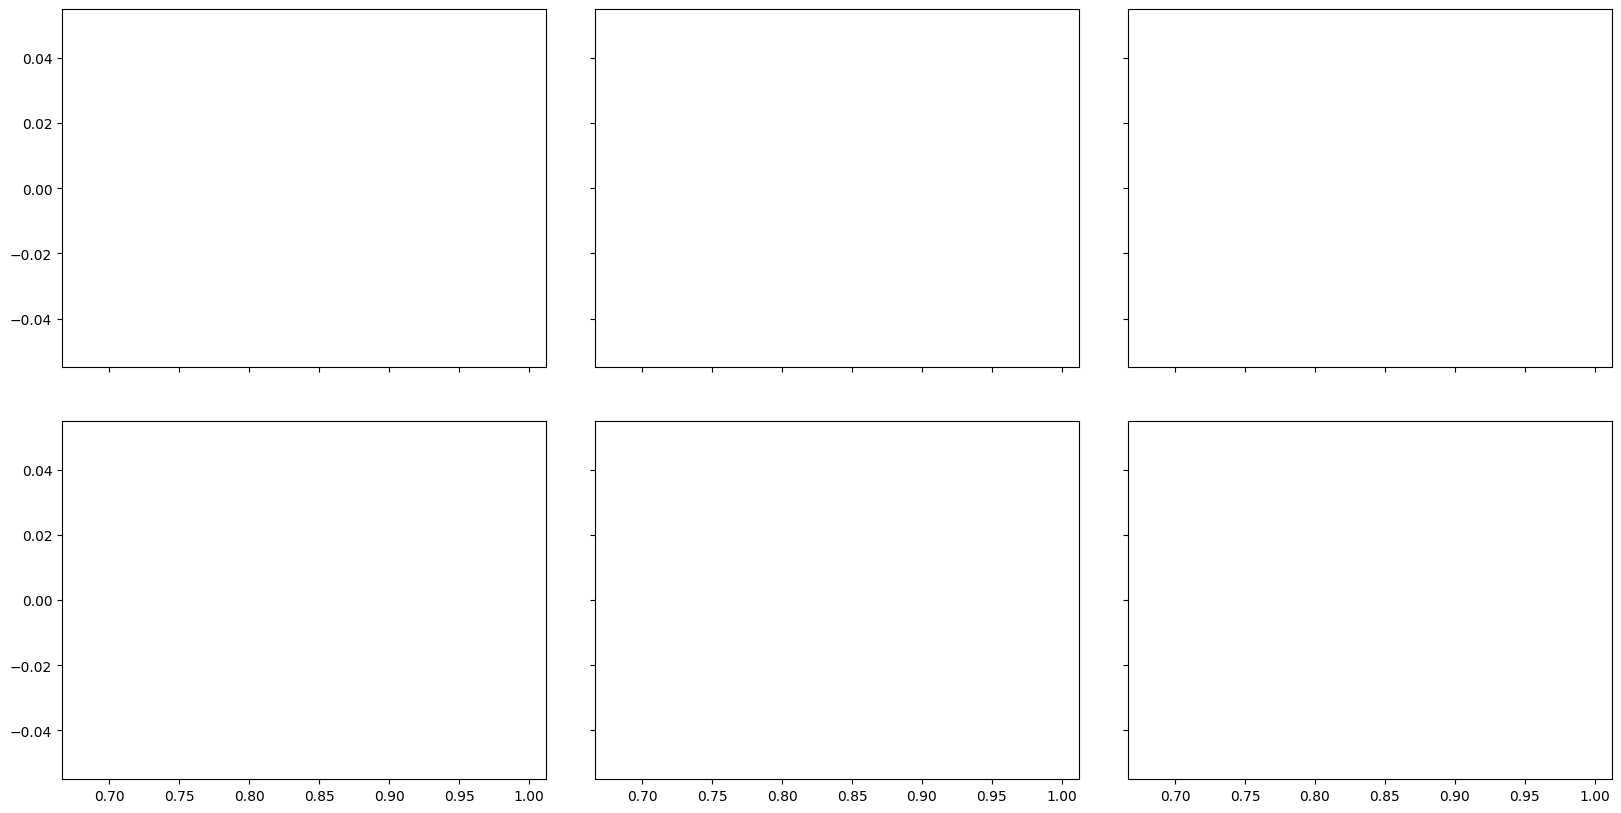

In [52]:
test_years = [2005, 2006, 2007, 2008, 2009, 2010]
labels = ["A", "B", "C", "D", "E", "F" ]
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
#fig.set_ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
#fig.set_xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0
for year in test_years: 
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]

    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
          #train data - does not have clinic
        X_train = train_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)
        if cipro_R > 0: 
          try:
              X_test, y_test = oversample.fit_resample(X_test,y_test)

          # test 
              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              get_effective_threshold_region = []
              incorrectly_get_X_threshold_region  = []
              for threshold in threshold_seq:

                y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

                tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

                sensitivity_test  = tp_test  / (tp_test   + fn_test )
                specificity_test   = tn_test / (tn_test + fp_test )
  
              get_effective_threshold_region.append(sensitivity_test * cipro_R + (1 -  cipro_R)) #q_p
              incorrectly_get_X_threshold_region.append((1 - cipro_R) * (1 - specificity_test)) #c_p
              axs[i].plot(get_effective_threshold_region, incorrectly_get_X_threshold_region,color = "black", linewidth = 3)

          except ValueError:
            try:
              oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)            
              X_test, y_test = oversample.fit_resample(X_test,y_test)

            # test 
              model_fit_train = model_nn.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              get_effective_threshold_region = []
              incorrectly_get_X_threshold_region  = []
              for threshold in threshold_seq:

                y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

                tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

                sensitivity_test  = tp_test  / (tp_test   + fn_test )
                specificity_test   = tn_test / (tn_test + fp_test )
  
                get_effective_threshold_region.append(sensitivity_test * cipro_R + (1 -  cipro_R)) #q_p
                incorrectly_get_X_threshold_region.append((1 - cipro_R) * (1 - specificity_test)) #c_p
              x = 0
              axs[i].plot(get_effective_threshold_region, incorrectly_get_X_threshold_region,color = "black", linewidth = 3)
              axs[i].plot([1, 1-cipro_R], [1-cipro_R, 0], color = "#e5e5e5", linestyle="--")


              if (i == 0) | (i == 3):
                axs[i].set_ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
              if(i == 3) | (i == 4) | (i == 5):
                axs[i].set_xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)

              axs[i].plot(1, 1 - cipro_R, marker='.', ls='none', ms=18, color = "black", label = "Dual")
              axs[i].plot((1-cipro_R), 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")
              axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.01, labels[i], fontsize = 16, **hfont)
              axs[i].title.set_text(year)
              if i == 0:
                axs[i].legend(loc = "upper left")

              for index in indices:
                axs[i].plot(get_effective_threshold_region[index], incorrectly_get_X_threshold_region[index], marker='.', ls='none', ms=11, color = "#b56576")
                if get_effective_threshold_region[index] > 0.996:
                  axs[i].text(get_effective_threshold_region[index] + 0.002, incorrectly_get_X_threshold_region[index] + 0.001, text_for_graph[x], size = 9)
                elif (get_effective_threshold_region[index] > 0.95) & (get_effective_threshold_region[index] < 0.996):
                  axs[i].text(get_effective_threshold_region[index] + 0.005, incorrectly_get_X_threshold_region[index] - 0.005, text_for_graph[x], size = 9)
                else:
                  axs[i].text(get_effective_threshold_region[index], incorrectly_get_X_threshold_region[index] + 0.025, text_for_graph[x], size = 9)
                x = x+1
              i += 1   
              #plt.plot(get_effective_threshold_region , incorrectly_get_X_threshold_region , color = "gray", alpha = 0.5)
              #plt.plot(1, 1 - cipro_R, marker='.', ls='none', ms=10, color = "gray")
              #plt.plot((1-cipro_R), 0, marker='*', ls='none', ms=10, color = "gray")
            except ValueError:
              print('x')
              pass
            
    

In [ ]:
###### hyperparameter tuning for each model 

